<a href="https://colab.research.google.com/github/tmbharathiraja/pytorch/blob/main/LinearRegression%5CManualLinerRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem : Linear Calibration (Thermometer)

- **Task:** Map “unknown-scale” readings $t_u$ to true Celsius $t_c$ using a linear model.

$$
t_p = w\, t_u + b
$$

- **Interpretation:**
  - $w$: gain/scale (stretch/squeeze)
  - $b$: offset/bias (systematic shift)
- **Why linear?** Sensors are often approximately affine over normal ranges.
- **Goal:** Find $w,b$ that make predictions $t_p$ close to targets $t_c$ using mnnaually coded loss, gradient functions.


# Imports

In [ ]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

print(sys.version)
print(torch.__version__)
print(np.__version__)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
2.8.0+cu126
2.0.2


# Dataset

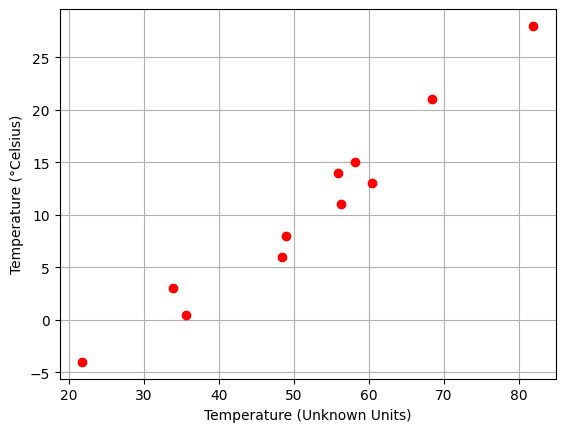

In [ ]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])

plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o', color='red')
plt.xlabel('Temperature (Unknown Units)')
plt.ylabel('Temperature (°Celsius)')
plt.show()

# Nonmalization

In [ ]:
t_u = 0.1 * t_u
t_c = 0.1 * t_c

# Model
Simple linear model  
$t_c = w \times t_u + b$




In [ ]:
def model(x, w, b):
    return w * x + b

# Loss Function - Mean Squared Error


$$
L(yp,y)=\frac{1}{N}\sum_{i=1}^{N}\Big(yp^{(i)}-y^{(i)}\Big)^2
$$

&emsp;&emsp;&emsp;yp : Predicted values.<br>
&emsp;&emsp;&emsp;y  : Acutal Values.

- **Intuition:** One scalar measures fit quality (smaller is better). Squaring emphasizes large errors and keeps derivatives smooth.
- **Sanity checks:** Evaluate loss for multiple $(w,b)$ guesses to confirm expected behavior.


In [ ]:
def loss_fn(yp, y):
    squared_diffs = (yp - y)**2
    return squared_diffs.mean()

# Backword Propogation Gradients


- **Idea:** Approximate sensitivity of the loss with tiny nudges $\delta$ (central differences):

$$
\frac{\partial L}{\partial w}\approx\frac{L(w+\delta,b)-L(w-\delta,b)}{2\delta},\quad
\frac{\partial L}{\partial b}\approx\frac{L(w,b+\delta)-L(w,b-\delta)}{2\delta}
$$

- **Pros:** Simple, model-agnostic, great for gradient debugging.
- **Cons:** Extra loss evaluations; $\delta$ must be chosen carefully (too big → bias; too small → floating-point noise).


In [ ]:
def dmodel_dw(x, w, b):
    return x

In [ ]:
def dmodel_db(x, w, b):
    return 1.0

# Analytical Gradients

**Model & variables used in code**
- Prediction: **`yp = w * x + b`**
- Target: **`y`**
- Residual (error): **`e = yp - y`**
- Loss (MSE, mean reduction):  
  $$
  L \;=\; \frac{1}{N}\sum_{i=1}^{N}(yp^{(i)} - y^{(i)})^2 \;
  $$

**Gradient wrt predictions (matches `dloss_fn`)**
- Using MSE with **mean**:
  $$
  \frac{\partial L}{\partial yp} \;=\; \frac{2}{N}\sum_{i=1}^{N}(yp^{(i)}- y^{(i)}) \;
  $$


In [ ]:
def dloss_fn(yp, y):
    dsq_diffs = 2 * (yp - y) / yp.size(0)
    return dsq_diffs

In [ ]:
def grad_fn(x, y, yp, w, b):
    dloss_dtp = dloss_fn(yp, y)
    dloss_dw = dloss_dtp * dmodel_dw(x, w, b)
    dloss_db = dloss_dtp * dmodel_db(x, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

# Manual Gradient Descent Training Loop (No Autograd)

- **Update rule:**

$$
w \leftarrow w - \eta\,\frac{\partial L}{\partial w},\qquad
b \leftarrow b - \eta\,\frac{\partial L}{\partial b}
$$

- **Loop steps per epoch:**
  1. Forward: $yp = w\,x + b$
  2. Compute $L$ (MSE)
  3. Compute gradients (analytical)
  4. Update $w,b$ with learning rate $\eta$
  5. Track $L$ over epochs

- **Expected behavior:** Loss generally decreases; use plots to diagnose issues.


In [ ]:
def training_loop(n_epochs, learning_rate, params, x, y,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        yp = model(x, w, b)
        loss = loss_fn(yp, y)
        grad = grad_fn(x, y, yp, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>

    return params

In [ ]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    x = t_u,
    y = t_c,
    print_params = False)


Epoch 1, Loss 17.638847
Epoch 2, Loss 2.944970
Epoch 3, Loss 0.668645
...
Epoch 10, Loss 0.246408
Epoch 11, Loss 0.245671
...
Epoch 99, Loss 0.189708
Epoch 100, Loss 0.189163
...
Epoch 4000, Loss 0.029277
Epoch 5000, Loss 0.029276


# Output

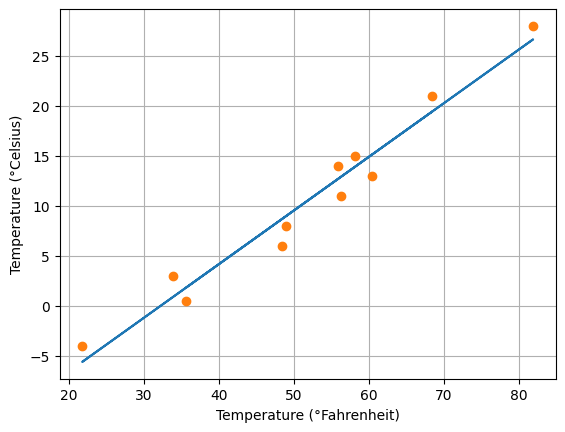

In [ ]:
t_p = model(t_u, *params)

#scale back
t_u *= 10
t_p *= 10
t_c *= 10

fig = plt.figure(dpi=100)
plt.grid(True)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")